In [1]:
import pandas as pd
import numpy as np
import xarray as xr
from scipy import stats
from random import random
from matplotlib import pyplot as plt

# 1-Day Satellite Composite

In [2]:
# List of file paths fot tag qualified tag detections (ECO-PAM missions from 2020, 2021, & 2022, and NJDEP Mission from 2022)
file_paths = [  'C:/Users/scott/Desktop/RUCOOL_Software_Bootcamp/Thesis coding/Qualified Detections/ecopam_qualified_detections_2022/ecopam_qualified_detections_2022.csv',
                'C:/Users/scott/Desktop/RUCOOL_Software_Bootcamp/Thesis coding/Qualified Detections/ecopam_qualified_detections_2021/ecopam_qualified_detections_2021.csv',
                'C:/Users/scott/Desktop/RUCOOL_Software_Bootcamp/Thesis coding/Qualified Detections/ecopam_qualified_detections_2020/ecopam_qualified_detections_2020.csv',
                'C:/Users/scott/Desktop/RUCOOL_Software_Bootcamp/Thesis coding/Qualified Detections/rmigliders_qualified_detections_2022/rmigliders_qualified_detections_2022.csv']

# Initialize an empty list to store DataFrames
all_detections = []

# Loop through each file path
for file_path in file_paths:
    # Read CSV file into DataFrame
    detection_data = pd.read_csv(file_path)
    # Convert 'datecollected' column to datetime
    detection_data['datecollected'] = pd.to_datetime(detection_data['datecollected'])
    
    # Append the DataFrame to the list
    all_detections.append(detection_data)

# Concatenate all DataFrames in the list into a single DataFrame
combined_detection_data = pd.concat(all_detections, ignore_index=True)

# Grab unique dates detections occured and convert to date format
unique_dates = combined_detection_data['datecollected'].dt.date.unique()

# empty column for water mass
combined_detection_data['WM'] = np.nan
# empty column for nearest Water Gradient above 1.5
combined_detection_data['WG'] = np.nan
# empty column for strongest Water Gradient within 1-km of detection
combined_detection_data['WG_1km'] = np.nan
# empty column for strongest Water Gradient within 5-km of detection
combined_detection_data['WG_5km'] = np.nan
# empty column for Distance to nearest Water Gradient above 1.5
combined_detection_data['WG_Dist'] = np.nan

# open satellite dataset - looks like I used 8-day but you can change the link to match the dataset you want to use. this accesses thredds instead of ERDDAP, 
#similar idea but less browser-based functionality. you can basically use it as a regular netcdf file, without having to actually download the whole huge file.
#the full list of thredds datasets is here: http://basin.ceoe.udel.edu/thredds/catalog/catalog.html
satdata = xr.open_dataset('http://basin.ceoe.udel.edu/thredds/dodsC/Aqua1DayAggregate.nc')

# subset to domain based on range of detections
satdata = satdata.sel(lon = slice(np.min(combined_detection_data['longitude'])-0.5, np.max(combined_detection_data['longitude'])+0.5),
                     lat = slice(np.min(combined_detection_data['latitude'])-0.5, np.max(combined_detection_data['latitude'])+0.5))

# generate 2d lon and lag grid (for calculating distance)
satgrid = np.meshgrid(satdata['lon'], satdata['lat'])

# define equation to get distance (km) from one lon/lat to another (or an entire set)
def haversine_dist(blon,blat,slon,slat):
    # blon: longitude of single point
    # blat: latitude of single point
    # slon: longitude(s) of grid
    # slat: latitude(s) of grid
    R = 6373.0
    blon=blon*np.pi/180
    blat=blat*np.pi/180
    slon=slon*np.pi/180
    slat=slat*np.pi/180
    dlon=slon-blon
    dlat=slat-blat
    a=np.sin(dlat/2)**2+np.cos(blat)*np.cos(slat)*np.sin(dlon/2)**2
    c=2*np.arctan2(np.sqrt(a),np.sqrt(1-a))
    distance=R*c
    return distance

# initialize domain-based background conditions for water mass and frontal gradient
wmdomain=np.array(None)
wgdomain=np.array(None)

# loop through unique dates
for t in unique_dates:
    # find matching time in satellite data
    ti = np.logical_and(satdata['time'].data>=np.datetime64(t), satdata['time'].data<=np.datetime64(t)+np.timedelta64(1,'D'))
    # only continue if there is one (and only one) matching date in satellite data
    if np.sum(ti)==1:
        # grab water mass layer
        wm = np.squeeze(satdata['M_WK'][np.where(ti)[0],:,:].data)
        # grab frontal gradient layer
        wg = np.squeeze(satdata['M_WK_G'][np.where(ti)[0],:,:].data)
        # loop through detections on date t from all combined detections
        for detection in np.where(combined_detection_data['datecollected'].dt.date == t)[0]:
            # calculate distance from sighting location to satellite grid points
            d = haversine_dist(combined_detection_data['longitude'][detection], combined_detection_data['latitude'][detection],
                               satgrid[0], satgrid[1])
            # grab water mass classifications within 1km
            wm_close = wm[d <= 1]
            # grab frontal gradients within 1km
            wg_close = wg[d <= 1]
            # grab frontal gradients within 5km
            wg_close2 = wg[d <= 5]
            # grab maximum gradient within 1km and assign to dataframe
            combined_detection_data.loc[detection, 'WG_1km'] = np.max(wg_close)
            # grab maximum gradient within 5km and assign to dataframe
            combined_detection_data.loc[detection, 'WG_5km'] = np.max(wg_close2)
            # grab most common water mass category within 1km and assign to dataframe
            combined_detection_data.loc[detection, 'WM'] = stats.mode(wm_close, keepdims=False).mode
            # Find the index of the minimum distance
            min_dist_index = np.argmin(d)
            #if 1==2:
            if wg.flatten()[min_dist_index] > 1.5:
                # Assign the value of the nearest frontal gradient to the DataFrame
                combined_detection_data.at[detection, 'WG'] = wg.flatten()[min_dist_index]

In [3]:
unique_dates

array([datetime.date(2022, 1, 30), datetime.date(2022, 4, 4),
       datetime.date(2022, 2, 8), datetime.date(2022, 6, 2),
       datetime.date(2022, 6, 4), datetime.date(2022, 5, 24),
       datetime.date(2022, 3, 3), datetime.date(2022, 2, 5),
       datetime.date(2022, 3, 9), datetime.date(2022, 4, 5),
       datetime.date(2022, 3, 4), datetime.date(2022, 2, 2),
       datetime.date(2022, 1, 19), datetime.date(2022, 1, 18),
       datetime.date(2021, 3, 1), datetime.date(2020, 12, 10),
       datetime.date(2020, 12, 9), datetime.date(2020, 11, 19),
       datetime.date(2020, 10, 16), datetime.date(2020, 10, 22),
       datetime.date(2020, 10, 12), datetime.date(2020, 10, 23),
       datetime.date(2020, 10, 8), datetime.date(2020, 11, 21),
       datetime.date(2020, 11, 26), datetime.date(2020, 12, 20),
       datetime.date(2020, 8, 25), datetime.date(2020, 12, 13),
       datetime.date(2020, 12, 11), datetime.date(2020, 10, 25),
       datetime.date(2020, 8, 21), datetime.date(2020,

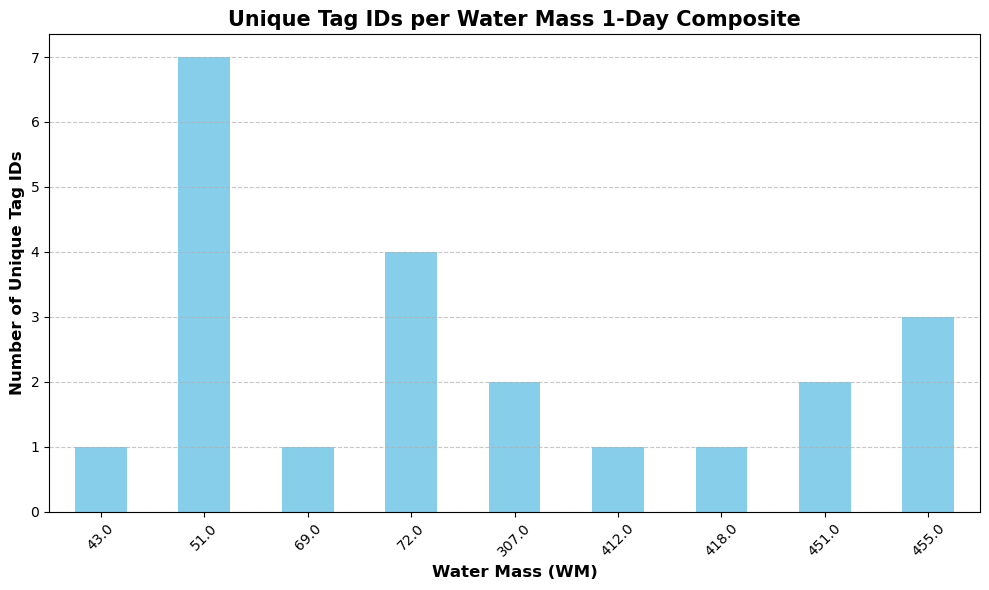

In [4]:
# group by Water Mass and get count of unique fieldnumbers for each Water Mass
counts_per_WM = combined_detection_data.groupby('WM')['fieldnumber'].nunique()

# plot the histogram and make it look nice
plt.figure(figsize=(10, 6))
counts_per_WM.plot(kind='bar', color='skyblue')
plt.xlabel('Water Mass (WM)', fontsize=12, fontweight='bold')
plt.ylabel('Number of Unique Tag IDs', fontsize=12, fontweight='bold')
plt.title('Unique Tag IDs per Water Mass 1-Day Composite', fontsize=15, fontweight='bold')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('C:/Users/scott/Desktop/RUCOOL_Software_Bootcamp/Unique Tag IDs per Water Mass 1-Day Composite.png', dpi=300, bbox_inches='tight', format="png")
plt.show()


In [5]:
counts_per_WM

WM
43.0     1
51.0     7
69.0     1
72.0     4
307.0    2
412.0    1
418.0    1
451.0    2
455.0    3
Name: fieldnumber, dtype: int64

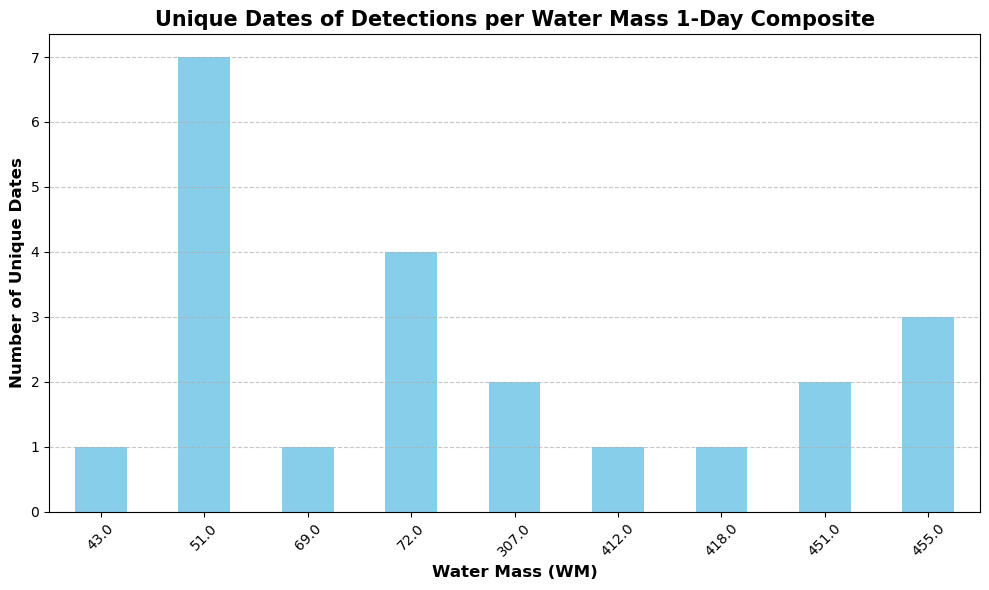

In [6]:
# group by Water Mass and get count of unique Dates for each Water Mass
counts_per_WM_date = combined_detection_data.groupby('WM')['datecollected'].nunique()

# plot the histogram and make it look nice
plt.figure(figsize=(10, 6))
counts_per_WM.plot(kind='bar', color='skyblue')
plt.xlabel('Water Mass (WM)', fontsize=12, fontweight='bold')
plt.ylabel('Number of Unique Dates', fontsize=12, fontweight='bold')
plt.title('Unique Dates of Detections per Water Mass 1-Day Composite', fontsize=15, fontweight='bold')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('C:/Users/scott/Desktop/RUCOOL_Software_Bootcamp/Unique Dates of Detections per Water Mass 1-Day Composite.png', dpi=300, bbox_inches='tight', format="png")
plt.show()


In [7]:
counts_per_WM_date

WM
43.0       4
51.0      73
69.0       2
72.0      42
307.0     18
412.0     17
418.0     27
451.0    142
455.0    218
Name: datecollected, dtype: int64

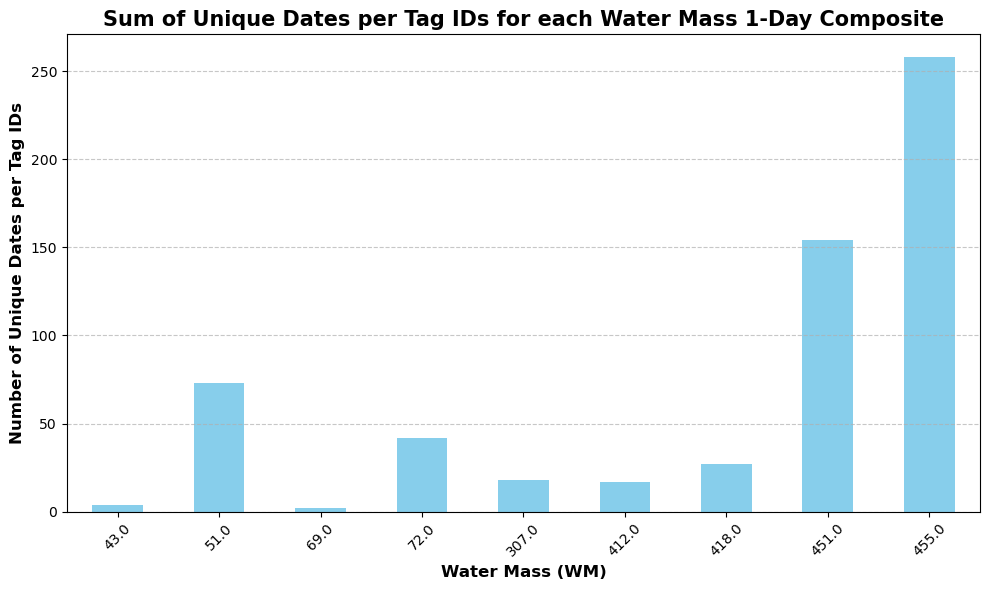

In [8]:
# Group by Water Mass and Date and get the number field numbers for ea
unique_dates_per_WM_fieldnumber = combined_detection_data.groupby(['WM', 'datecollected'])['fieldnumber'].nunique()

#Sum the counts per 'WM' to get the total count for each water mass category
counts_per_WM = unique_dates_per_WM_fieldnumber.groupby('WM').sum()

plt.figure(figsize=(10, 6))
counts_per_WM.plot(kind='bar', color='skyblue')
plt.xlabel('Water Mass (WM)', fontsize=12, fontweight='bold')
plt.ylabel('Number of Unique Dates per Tag IDs', fontsize=12, fontweight='bold')
plt.title('Sum of Unique Dates per Tag IDs for each Water Mass 1-Day Composite', fontsize=15, fontweight='bold')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('C:/Users/scott/Desktop/RUCOOL_Software_Bootcamp/Sum of Unique Dates per Tag IDs for each Water Mass 1-Day Composite.png', dpi=300, bbox_inches='tight', format="png")
plt.show()


In [9]:
unique_dates_per_WM_fieldnumber

WM     datecollected      
43.0   2020-11-20 09:10:48    1
       2020-11-20 09:12:45    1
       2020-11-20 09:15:05    1
       2020-11-20 09:17:10    1
51.0   2020-12-10 00:00:03    1
                             ..
455.0  2022-06-02 15:47:00    1
       2022-06-02 15:49:00    1
       2022-06-02 15:51:00    1
       2022-06-02 15:53:00    1
       2022-06-02 15:56:00    1
Name: fieldnumber, Length: 543, dtype: int64

# 3-Day Satellite Composite

In [12]:
# List of file paths fot tag qualified tag detections (ECO-PAM missions from 2020, 2021, & 2022, and NJDEP Mission from 2022)
file_paths = [  'C:/Users/scott/Desktop/RUCOOL_Software_Bootcamp/Thesis coding/Qualified Detections/ecopam_qualified_detections_2022/ecopam_qualified_detections_2022.csv',
                'C:/Users/scott/Desktop/RUCOOL_Software_Bootcamp/Thesis coding/Qualified Detections/ecopam_qualified_detections_2021/ecopam_qualified_detections_2021.csv',
                'C:/Users/scott/Desktop/RUCOOL_Software_Bootcamp/Thesis coding/Qualified Detections/ecopam_qualified_detections_2020/ecopam_qualified_detections_2020.csv',
                'C:/Users/scott/Desktop/RUCOOL_Software_Bootcamp/Thesis coding/Qualified Detections/rmigliders_qualified_detections_2022/rmigliders_qualified_detections_2022.csv']

# Initialize an empty list to store DataFrames
all_detections = []

# Loop through each file path
for file_path in file_paths:
    # Read CSV file into DataFrame
    detection_data = pd.read_csv(file_path)
    # Convert 'datecollected' column to datetime
    detection_data['datecollected'] = pd.to_datetime(detection_data['datecollected'])
    
    # Append the DataFrame to the list
    all_detections.append(detection_data)

# Concatenate all DataFrames in the list into a single DataFrame
combined_detection_data1 = pd.concat(all_detections, ignore_index=True)

# Grab unique dates detections occured and convert to date format
unique_dates = combined_detection_data1['datecollected'].dt.date.unique()

# empty column for water mass
combined_detection_data1['WM'] = np.nan
# empty column for nearest Water Gradient above 1.5
combined_detection_data1['WG'] = np.nan
# empty column for strongest Water Gradient within 1-km of detection
combined_detection_data1['WG_1km'] = np.nan
# empty column for strongest Water Gradient within 5-km of detection
combined_detection_data1['WG_5km'] = np.nan
# empty column for Distance to nearest Water Gradient above 1.5
combined_detection_data1['WG_Dist'] = np.nan

# open satellite dataset - looks like I used 8-day but you can change the link to match the dataset you want to use. this accesses thredds instead of ERDDAP, 
#similar idea but less browser-based functionality. you can basically use it as a regular netcdf file, without having to actually download the whole huge file.
#the full list of thredds datasets is here: http://basin.ceoe.udel.edu/thredds/catalog/catalog.html
satdata2 = xr.open_dataset('http://basin.ceoe.udel.edu/thredds/dodsC/Aqua3DayAggregate.nc')
# subset to domain based on range of detections
satdata2 = satdata2.sel(lon = slice(np.min(combined_detection_data1['longitude'])-0.5, np.max(combined_detection_data1['longitude'])+0.5),
                     lat = slice(np.min(combined_detection_data1['latitude'])-0.5, np.max(combined_detection_data1['latitude'])+0.5))
# generate 2d lon and lag grid (for calculating distance)
satgrid2 = np.meshgrid(satdata2['lon'], satdata2['lat'])

# define equation to get distance (km) from one lon/lat to another (or an entire set)
def haversine_dist(blon,blat,slon,slat):
    # blon: longitude of single point
    # blat: latitude of single point
    # slon: longitude(s) of grid
    # slat: latitude(s) of grid
    R = 6373.0
    blon=blon*np.pi/180
    blat=blat*np.pi/180
    slon=slon*np.pi/180
    slat=slat*np.pi/180
    dlon=slon-blon
    dlat=slat-blat
    a=np.sin(dlat/2)**2+np.cos(blat)*np.cos(slat)*np.sin(dlon/2)**2
    c=2*np.arctan2(np.sqrt(a),np.sqrt(1-a))
    distance=R*c
    return distance

# initialize domain-based background conditions for water mass and frontal gradient
wmdomain=np.array(None)
wgdomain=np.array(None)

# loop through unique dates
for t in unique_dates:
    # find matching time in satellite data
    ti = np.logical_and(satdata2['time'].data>=np.datetime64(t), satdata2['time'].data<=np.datetime64(t)+np.timedelta64(1,'D'))
    # only continue if there is one (and only one) matching date in satellite data
    if np.sum(ti)==1:
        # grab water mass layer
        wm = np.squeeze(satdata2['M_WK'][np.where(ti)[0],:,:].data)
        # grab frontal gradient layer
        wg = np.squeeze(satdata2['M_WK_G'][np.where(ti)[0],:,:].data)
        # loop through detections on date t from all combined detections
        for detection in np.where(combined_detection_data1['datecollected'].dt.date == t)[0]:
            # calculate distance from sighting location to satellite grid points
            d = haversine_dist(combined_detection_data1['longitude'][detection], combined_detection_data1['latitude'][detection],
                               satgrid2[0], satgrid2[1])
            # grab water mass classifications within 1km
            wm_close = wm[d <= 1]
            # grab frontal gradients within 1km
            wg_close = wg[d <= 1]
            # grab frontal gradients within 5km
            wg_close2 = wg[d <= 5]
            # grab maximum gradient within 1km and assign to dataframe
            combined_detection_data1.loc[detection, 'WG_1km'] = np.max(wg_close)
            # grab maximum gradient within 5km and assign to dataframe
            combined_detection_data1.loc[detection, 'WG_5km'] = np.max(wg_close2)
            # grab most common water mass category within 1km and assign to dataframe
            combined_detection_data1.loc[detection, 'WM'] = stats.mode(wm_close, keepdims=False).mode
            # Find the index of the minimum distance
            min_dist_index = np.argmin(d)
            #if 1==2:
            if wg.flatten()[min_dist_index] > 1.5:
                # Assign the value of the nearest frontal gradient to the DataFrame
                combined_detection_data1.at[detection, 'WG'] = wg.flatten()[min_dist_index]

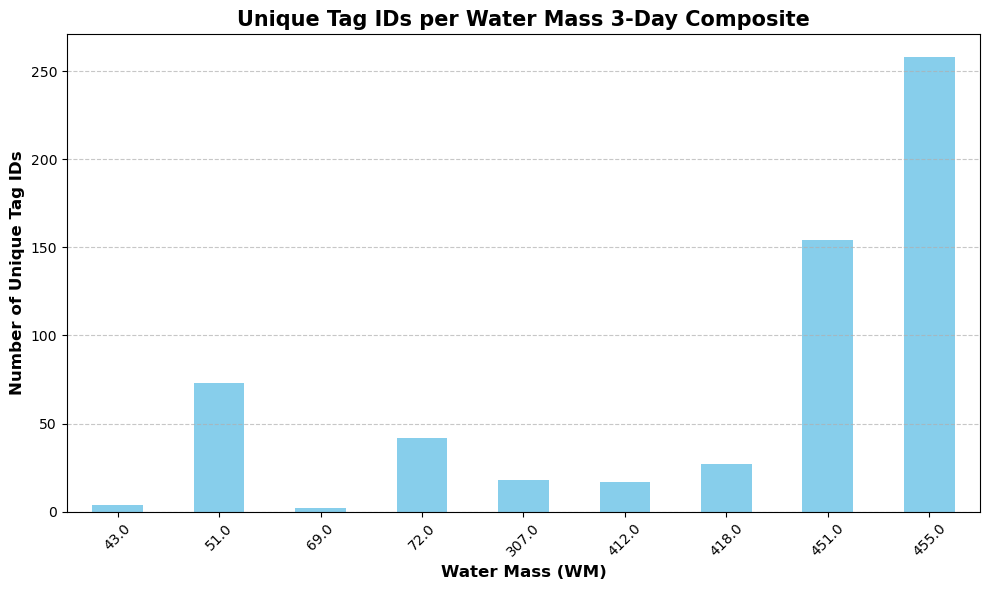

In [13]:
# group by Water Mass and get count of unique fieldnumbers for each Water Mass
counts_per_WM1 = combined_detection_data1.groupby('WM')['fieldnumber'].nunique()

plt.figure(figsize=(10, 6))
counts_per_WM.plot(kind='bar', color='skyblue')
plt.xlabel('Water Mass (WM)', fontsize=12, fontweight='bold')
plt.ylabel('Number of Unique Tag IDs', fontsize=12, fontweight='bold')
plt.title('Unique Tag IDs per Water Mass 3-Day Composite', fontsize=15, fontweight='bold')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('C:/Users/scott/Desktop/RUCOOL_Software_Bootcamp/Unique Tag IDs per Water Mass 3-Day Composite.png', dpi=300, bbox_inches='tight', format="png")
plt.show()


In [14]:
counts_per_WM1

WM
44.0     1
51.0     2
69.0     2
273.0    1
307.0    1
418.0    1
451.0    4
455.0    3
Name: fieldnumber, dtype: int64

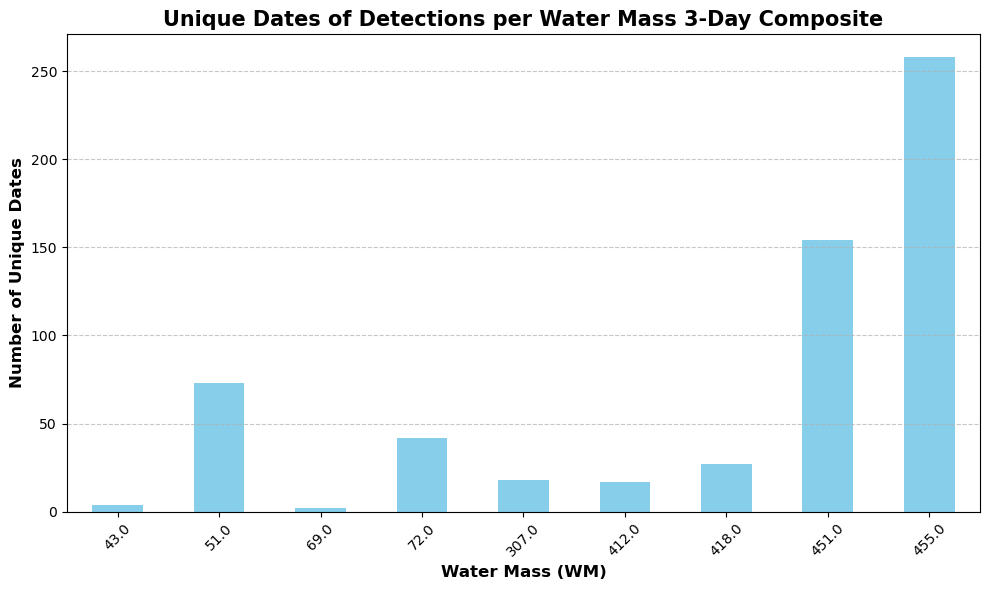

In [15]:
counts_per_WM_dates1 = combined_detection_data.groupby('WM')['datecollected'].nunique()

plt.figure(figsize=(10, 6))
counts_per_WM.plot(kind='bar', color='skyblue')
plt.xlabel('Water Mass (WM)', fontsize=12, fontweight='bold')
plt.ylabel('Number of Unique Dates', fontsize=12, fontweight='bold')
plt.title('Unique Dates of Detections per Water Mass 3-Day Composite', fontsize=15, fontweight='bold')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('C:/Users/scott/Desktop/RUCOOL_Software_Bootcamp/Unique Dates of Detections per Water Mass 3-Day Composite.png', dpi=300, bbox_inches='tight', format="png")
plt.show()


In [16]:
counts_per_WM_dates1

WM
43.0       4
51.0      73
69.0       2
72.0      42
307.0     18
412.0     17
418.0     27
451.0    142
455.0    218
Name: datecollected, dtype: int64

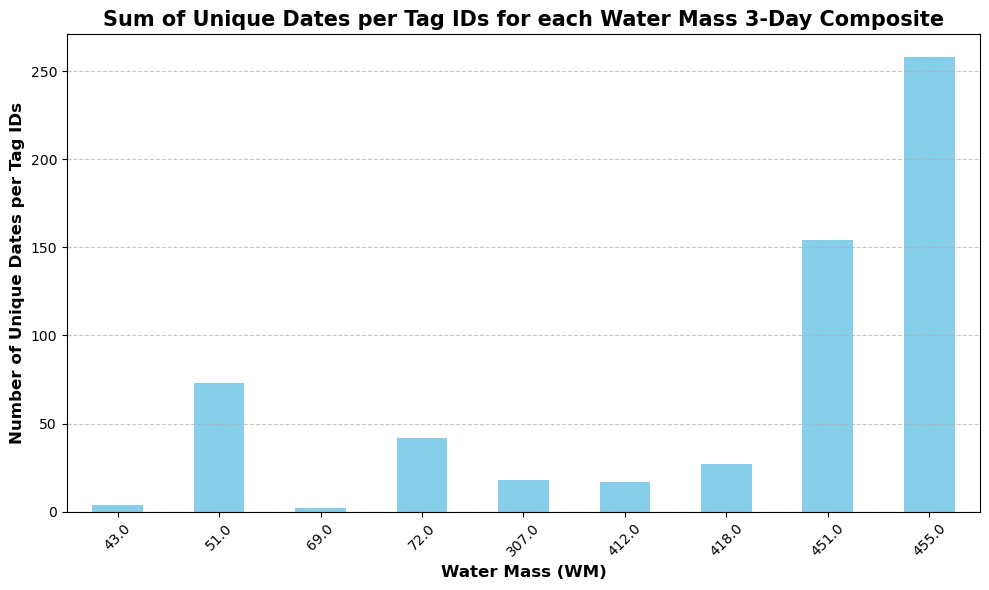

In [17]:
unique_dates_per_WM_fieldnumber1 = combined_detection_data.groupby(['WM', 'fieldnumber'])['datecollected'].nunique()

#Sum the counts per 'WM' to get the total count for each water mass category
counts_per_WM = unique_dates_per_WM_fieldnumber.groupby('WM').sum()

plt.figure(figsize=(10, 6))
counts_per_WM.plot(kind='bar', color='skyblue')
plt.xlabel('Water Mass (WM)', fontsize=12, fontweight='bold')
plt.ylabel('Number of Unique Dates per Tag IDs', fontsize=12, fontweight='bold')
plt.title('Sum of Unique Dates per Tag IDs for each Water Mass 3-Day Composite', fontsize=15, fontweight='bold')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('C:/Users/scott/Desktop/RUCOOL_Software_Bootcamp/Sum of Unique Dates per Tag IDs for each Water Mass 3-Day Composite.png', dpi=300, bbox_inches='tight', format="png")
plt.show()


In [18]:
unique_dates_per_WM_fieldnumber1

WM     fieldnumber   
43.0   A69-9002-6773       4
51.0   A69-1602-20938     25
       A69-1602-20952      5
       A69-1602-20954     12
       A69-1602-49608     11
       A69-9001-17812      4
       A69-9001-21793     13
       A69-9001-21830      3
69.0   A69-9001-21820      2
72.0   A69-9001-12730     16
       A69-9001-13443     11
       A69-9001-18629      5
       A69-9001-6464      10
307.0  A69-9001-23325      3
       A69-9001-64170     15
412.0  A69-9001-23978     17
418.0  A69-9001-23978     27
451.0  A69-9001-12078     27
       A69-9001-5324     127
455.0  A69-9001-12078     86
       A69-9001-23922     17
       A69-9001-5324     155
Name: datecollected, dtype: int64

In [19]:
non_null_count = combined_detection_data['WM'].notnull().sum()

# Count NaN values for 'WM' column
nan_count = combined_detection_data['WM'].isnull().sum()

print("Non-null count for 'WM':", non_null_count)
print("NaN count for 'WM':", nan_count)

Non-null count for 'WM': 598
NaN count for 'WM': 469


In [20]:
non_null_count = combined_detection_data1['WM'].notnull().sum()

# Count NaN values for 'WM' column
nan_count = combined_detection_data1['WM'].isnull().sum()

print("Non-null count for 'WM':", non_null_count)
print("NaN count for 'WM':", nan_count)

Non-null count for 'WM': 522
NaN count for 'WM': 545


In [21]:
combined_detection_data1['WM']

0       51.0
1       51.0
2       51.0
3       51.0
4       51.0
        ... 
1062    69.0
1063    69.0
1064    69.0
1065    69.0
1066     NaN
Name: WM, Length: 1067, dtype: float64

In [22]:
combined_detection_data['WM']

0       51.0
1       51.0
2       51.0
3       51.0
4       51.0
        ... 
1062     NaN
1063     NaN
1064     NaN
1065     NaN
1066     NaN
Name: WM, Length: 1067, dtype: float64